# Train a fully connected (dense) neural network for EMNIST Digits

In [1]:
using Flux
using Statistics
using MLDatasets
using DataFrames
using OneHotArrays
using CairoMakie
using ProgressBars

## MNIST dataset

In [2]:
train_data = MNIST(split = :train)
test_data = MNIST(split = :test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

### Data Exploration and Visualisation

Note this version of the dataset uses floats in the range [0,1] for the pixel intensity, data features are a 28x28 array. Labels are simple integers.

In [3]:
train_data.features[:, :, 1]

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  

In [4]:
train_data.targets[1]

5

In [5]:
"""
    pos(v, cols)

Map an integer value to a [row, col] position in a grid of `cols` columns.
"""
function pos(v, cols)
    return div(v - 1, cols) + 1, mod1(v, cols)
end;

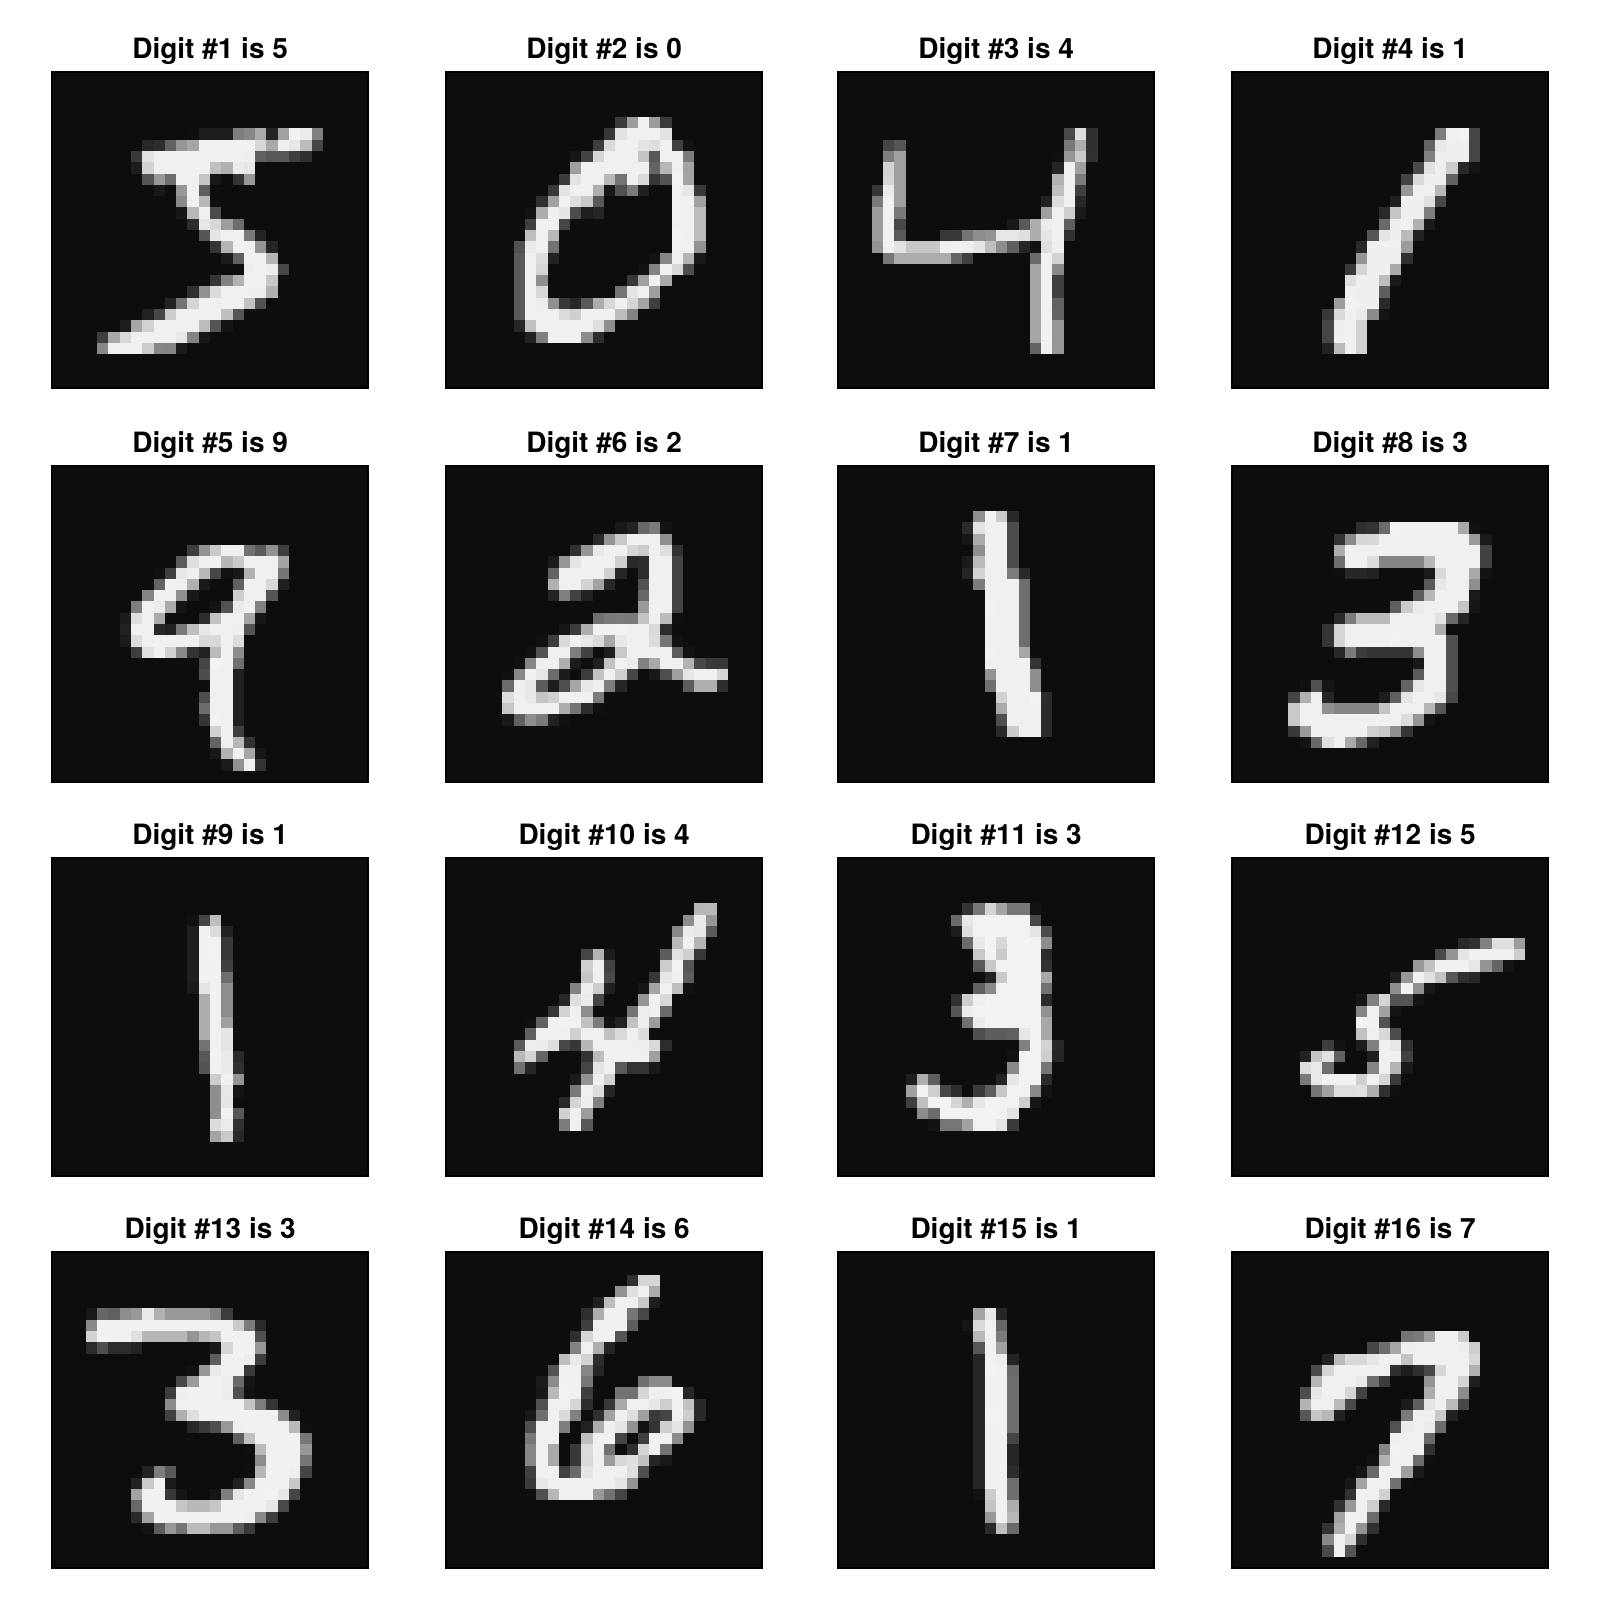

In [6]:
# Now plot a bunch of the first digits
#
# Note that the orientation is with the lowest row at the bottom of the visualisation,
# hence the `yreversed=true` in the Axis.
f = Figure(size=(800,800))
for d in 1:16
    ax = Axis(f[pos(d,4)...], aspect = DataAspect(), yreversed=true,
        title = "Digit #$d is $(Int(train_data.targets[d]))",)
    hidedecorations!(ax)
    heatmap!(ax, train_data.features[:, :, d], 
        colormap = :grays,
    )
end
f

## Network Definition

We define a network that takes the 28x28 input image array (vector of 784), passes it through two hidden layers of 1000 neurons, then the output layer is 10 neurons, passed through softmax.

In [7]:
dense_model = Chain(
    Dense(28 * 28, 1000, relu),
    Dense(1000, 1000, relu),
    Dense(1000, 10),
    softmax
)

Chain(
  Dense(784 => 1000, relu),             # 785_000 parameters
  Dense(1000 => 1000, relu),            # 1_001_000 parameters
  Dense(1000 => 10),                    # 10_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 1_796_010 parameters, 6.852 MiB.

In [8]:
# Random test of the initial model on one data point
dense_model(reshape(train_data.features[:, :, 1], (784, 1)))

10×1 Matrix{Float32}:
 0.10858307
 0.09926325
 0.1432535
 0.15114485
 0.10237258
 0.108695485
 0.07236507
 0.07622522
 0.055083025
 0.08301397

In [9]:
const classes = sort(unique(train_data.targets))

10-element Vector{Int64}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [10]:
train_y = onehotbatch(train_data.targets, classes)
test_y = onehotbatch(test_data.targets, classes);

In [11]:
train_x = reshape(train_data.features, (28 * 28, size(train_data.features, 3)));
test_x = reshape(test_data.features, (28 * 28, size(test_data.features, 3)));

In [12]:
# Define a tuple with the data and features (Flux wants this format)
train_dataset = [(train_x, train_y)];
test_dataset = [(test_x, test_y)];

In [13]:
"""
    measure_loss(flux_model, features, labels_onehot)

Calculate the loss for a Flux model given the features and one-hot encoded labels.
"""
function measure_loss(flux_model, features, labels_onehot)
    ŷ = flux_model(features)
    Flux.logitcrossentropy(ŷ, labels_onehot)
end;

In [14]:
"""
    measure_accuracy(x, y)

Calculate the accuracy of the model predictions against the true labels.
"""
measure_accuracy(x, y) = mean(Flux.onecold(dense_model(x), classes) .== y);

## Training Loops

### Loop using `train!`

In [15]:
opt_state = Flux.setup(Adam(), dense_model);

In [16]:
# Now run for a decent number of epochs
epochs = 200
accuracy = Vector{Float32}()
push!(accuracy, measure_accuracy(train_x, train_data.targets))
test_accuracy = Vector{Float32}()
push!(test_accuracy, measure_accuracy(test_x, test_data.targets))
loss = Vector{Float32}()
push!(loss, measure_loss(dense_model, train_x, train_y))
start = time()
for i in 1:epochs
    Flux.train!(dense_model, train_dataset, opt_state) do m, x, y
        measure_loss(m, x, y)
    end
    acc = measure_accuracy(train_x, train_data.targets)
    push!(accuracy, acc)
    test_acc = measure_accuracy(test_x, test_data.targets)
    push!(test_accuracy, test_acc)
    l = measure_loss(dense_model, train_x, train_y)
    push!(loss, l)
    if i % 5 == 0
        elapsed = time() - start
        println("Accuracy after epoch $i: $acc (train), $test_acc (test); loss: $l; $(round(elapsed, digits=2))s ($(round(elapsed / i, digits=2))s/epoch)")
    end
end


Accuracy after epoch 5: 0.7297833333333333 (train), 0.7392 (test); loss: 1.7986194; 26.78s (5.36s/epoch)
Accuracy after epoch 10: 0.7993833333333333 (train), 0.8047 (test); loss: 1.6734964; 45.73s (4.57s/epoch)
Accuracy after epoch 15: 0.8346833333333333 (train), 0.8382 (test); loss: 1.637494; 64.84s (4.32s/epoch)
Accuracy after epoch 20: 0.8997833333333334 (train), 0.9009 (test); loss: 1.5709103; 85.11s (4.26s/epoch)
Accuracy after epoch 25: 0.9077333333333333 (train), 0.9076 (test); loss: 1.5595807; 102.53s (4.1s/epoch)
Accuracy after epoch 30: 0.9179833333333334 (train), 0.9193 (test); loss: 1.548229; 120.41s (4.01s/epoch)
Accuracy after epoch 35: 0.92715 (train), 0.9249 (test); loss: 1.5385381; 139.01s (3.97s/epoch)
Accuracy after epoch 40: 0.9338166666666666 (train), 0.9324 (test); loss: 1.5314316; 156.08s (3.9s/epoch)
Accuracy after epoch 45: 0.9403 (train), 0.9359 (test); loss: 1.5254287; 172.62s (3.84s/epoch)
Accuracy after epoch 50: 0.9448166666666666 (train), 0.9404 (test); l

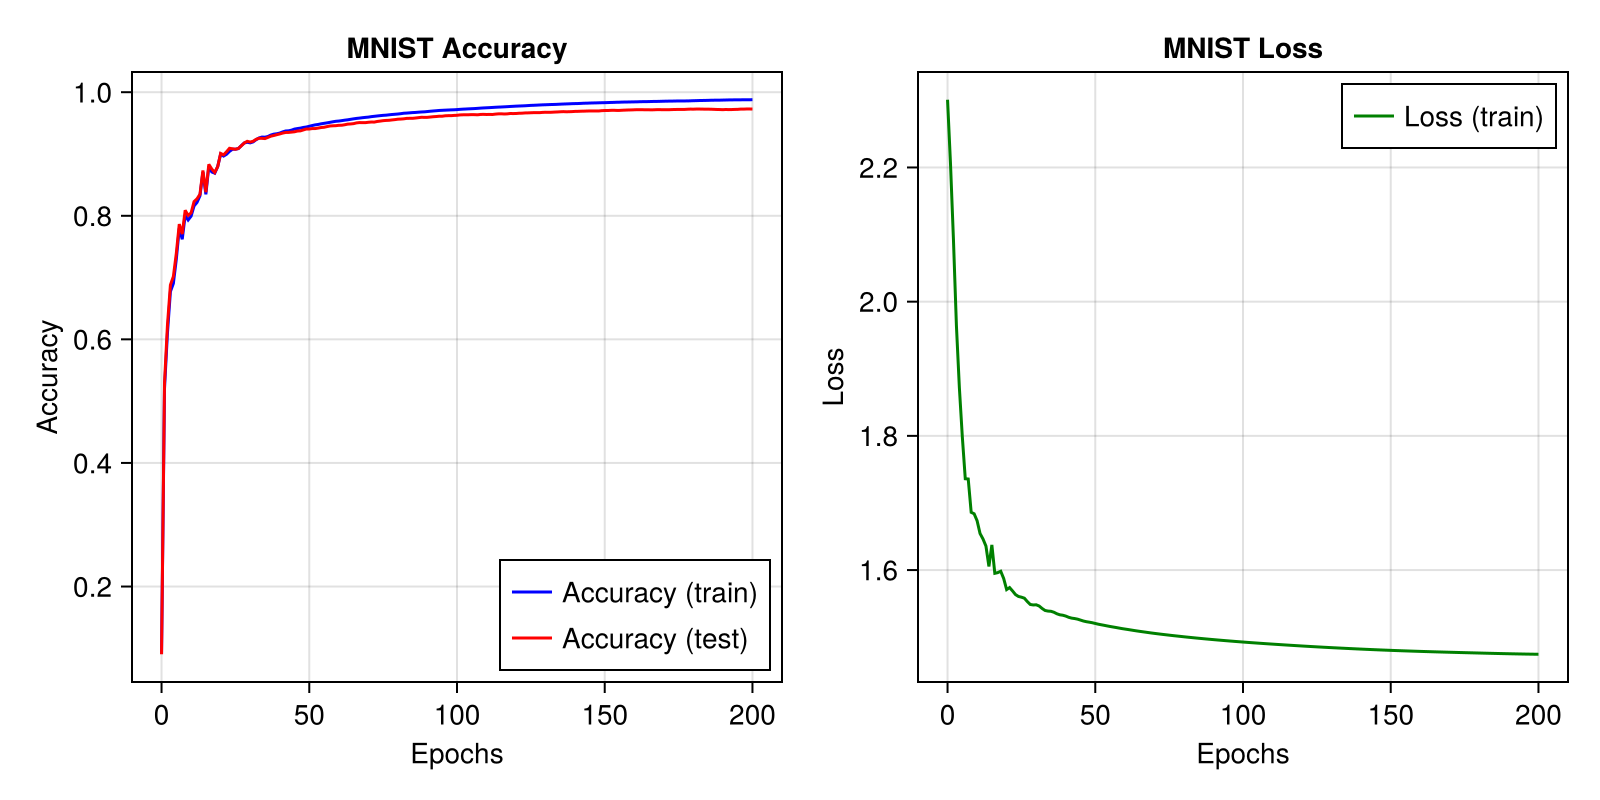

In [17]:
let 
    f = Figure(size=(800, 400))
    epochs = collect(0:length(accuracy)-1)
    ax_acc = Axis(f[1, 1],
        title = "MNIST Accuracy",
        xlabel = "Epochs",
        ylabel = "Accuracy",)
    lines!(ax_acc, epochs, accuracy, label = "Accuracy (train)", color = :blue)
    lines!(ax_acc, epochs, test_accuracy, label = "Accuracy (test)", color = :red)
    axislegend(position = :rb)
    ax_loss = Axis(f[1, 2],
        title = "MNIST Loss",
        xlabel = "Epochs",
        ylabel = "Loss",)
    lines!(ax_loss, epochs, loss, label = "Loss (train)", color = :green)
    axislegend(position = :rt)
    save(joinpath("plots", "mnist-full-train.png"), f)
    f
end